# LeNet - 5 / MNIST

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
sys.path.append('/content/drive/My Drive/Colab Notebooks')

In [ ]:
from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix
from helper_train_extended import train_model
from helper_plotting_extended import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_dataset_extended import get_dataloaders_mnist

## Nustatymai ir duomenų rinkinys

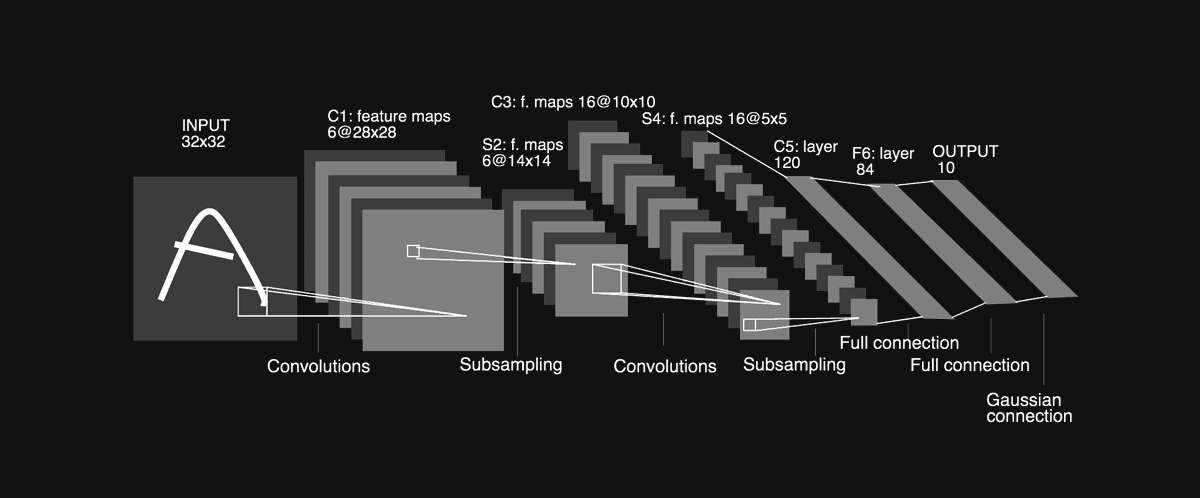

In [ ]:
FILES_DIR   = '/content/drive/My Drive/Colab Notebooks/dataloader'
RANDOM_SEED = 123
BATCH_SIZE  = 256
NUM_EPOCHS  = 15
DEVICE      = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
resize_transform = torchvision.transforms.Compose(
    [torchvision.transforms.Resize((32, 32)),
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5,), (0.5,))])


train_loader, valid_loader, test_loader = get_dataloaders_mnist(
    batch_size=BATCH_SIZE,
    validation_fraction=0.1,
    train_transforms=resize_transform,
    test_transforms=resize_transform)

for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

## Modelis

[architektrūra](https://www.analyticsvidhya.com/blog/2021/03/the-architecture-of-lenet-5/)

In [ ]:
class LeNet5(torch.nn.Module):

    def __init__(self, num_classes, grayscale=False):
        super().__init__()
        
        self.grayscale   = grayscale
        self.num_classes = num_classes

        if self.grayscale:
            in_channels = 1
        else:
            in_channels = 3

        self.features = torch.nn.Sequential(
            
            torch.nn.Conv2d(in_channels, 6, kernel_size=5),
            torch.nn.Tanh(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Conv2d(6, 16, kernel_size=5),
            torch.nn.Tanh(),
            torch.nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(16*5*5, 120),
            torch.nn.Tanh(),
            torch.nn.Linear(120, 84),
            torch.nn.Tanh(),
            torch.nn.Linear(84, num_classes),
        )


    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        return logits

In [1]:
model = LeNet5(grayscale=True, num_classes=10)
model = model.to(DEVICE)

# Daugiau detalių apie optim modulį: https://pytorch.org/docs/stable/optim.html

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    logging_interval=100)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=100)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([80, 100])
plt.show()

NameError: name 'LeNet5' is not defined

In [ ]:
model.cpu()
show_examples(model=model, data_loader=test_loader)

In [ ]:
class_dict = {0: '0',
              1: '1',
              2: '2',
              3: '3',
              4: '4',
              5: '5',
              6: '6',
              7: '7',
              8: '8',
              9: '9'}

mat = compute_confusion_matrix(model=model, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()